#IMPORT AND  INSTALLATION

In [12]:
# Install required packages
!pip install imbalanced-learn -q
!pip install tensorflow -q
!pip install keras-tuner -q

# Import libraries
import pandas as pd
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')
import joblib
import os
from google.colab import drive, files
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#DATA LOADING & INITIAL EXPLORATION

In [13]:
print("="*60)
print("TELCO CUSTOMER CHURN PREDICTION - COURSEWORK IMPLEMENTATION")
print("="*60)

# Download dataset from Kaggle (alternative method)
print("\n1. DOWNLOADING DATASET...")

# Method 1: Try loading from Google Drive path first
try:
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Telco-Customer-Churn.csv")
    print(f"   Dataset loaded successfully from Google Drive!")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {df.columns.tolist()}")

except FileNotFoundError:
    print("   File not found at Google Drive path. Trying alternative method...")

    # Method 2: Upload from local
    print("\n   Please upload the 'Telco-Customer-Churn.csv' file when prompted")
    from google.colab import files
    uploaded = files.upload()

    # Get the filename
    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"   Uploaded file: {filename}")

        # Load the dataset
        df = pd.read_csv(filename)
        print(f"   Dataset loaded successfully from uploaded file!")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {df.columns.tolist()}")
    else:
        print("    No file uploaded. Please try again.")
        raise FileNotFoundError("Telco-Customer-Churn.csv file not found")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\n Data loading completed!")

TELCO CUSTOMER CHURN PREDICTION - COURSEWORK IMPLEMENTATION

1. DOWNLOADING DATASET...
   Dataset loaded successfully from Google Drive!
   Shape: (7043, 21)
   Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



 Data loading completed!


#EXPLORATORY DATA ANALYSIS (EDA)


EXPLORATORY DATA ANALYSIS (EDA)

2.1 DATASET INFORMATION:
   Total samples: 7043
   Total features: 21

2.2 DATA TYPES:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

2.3 MISSING VALUES:
Series([], dtype: int64)

2.4 CLASS DISTRIBUTION (BEFORE BALANCING):
   No Churn:  5174 (73.5%)
   Churn:     1869 (26.5%)
   IMBALANCE RATIO: 2.77:1

2.5 NUMERICAL FEATURES STATISTICS:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000   

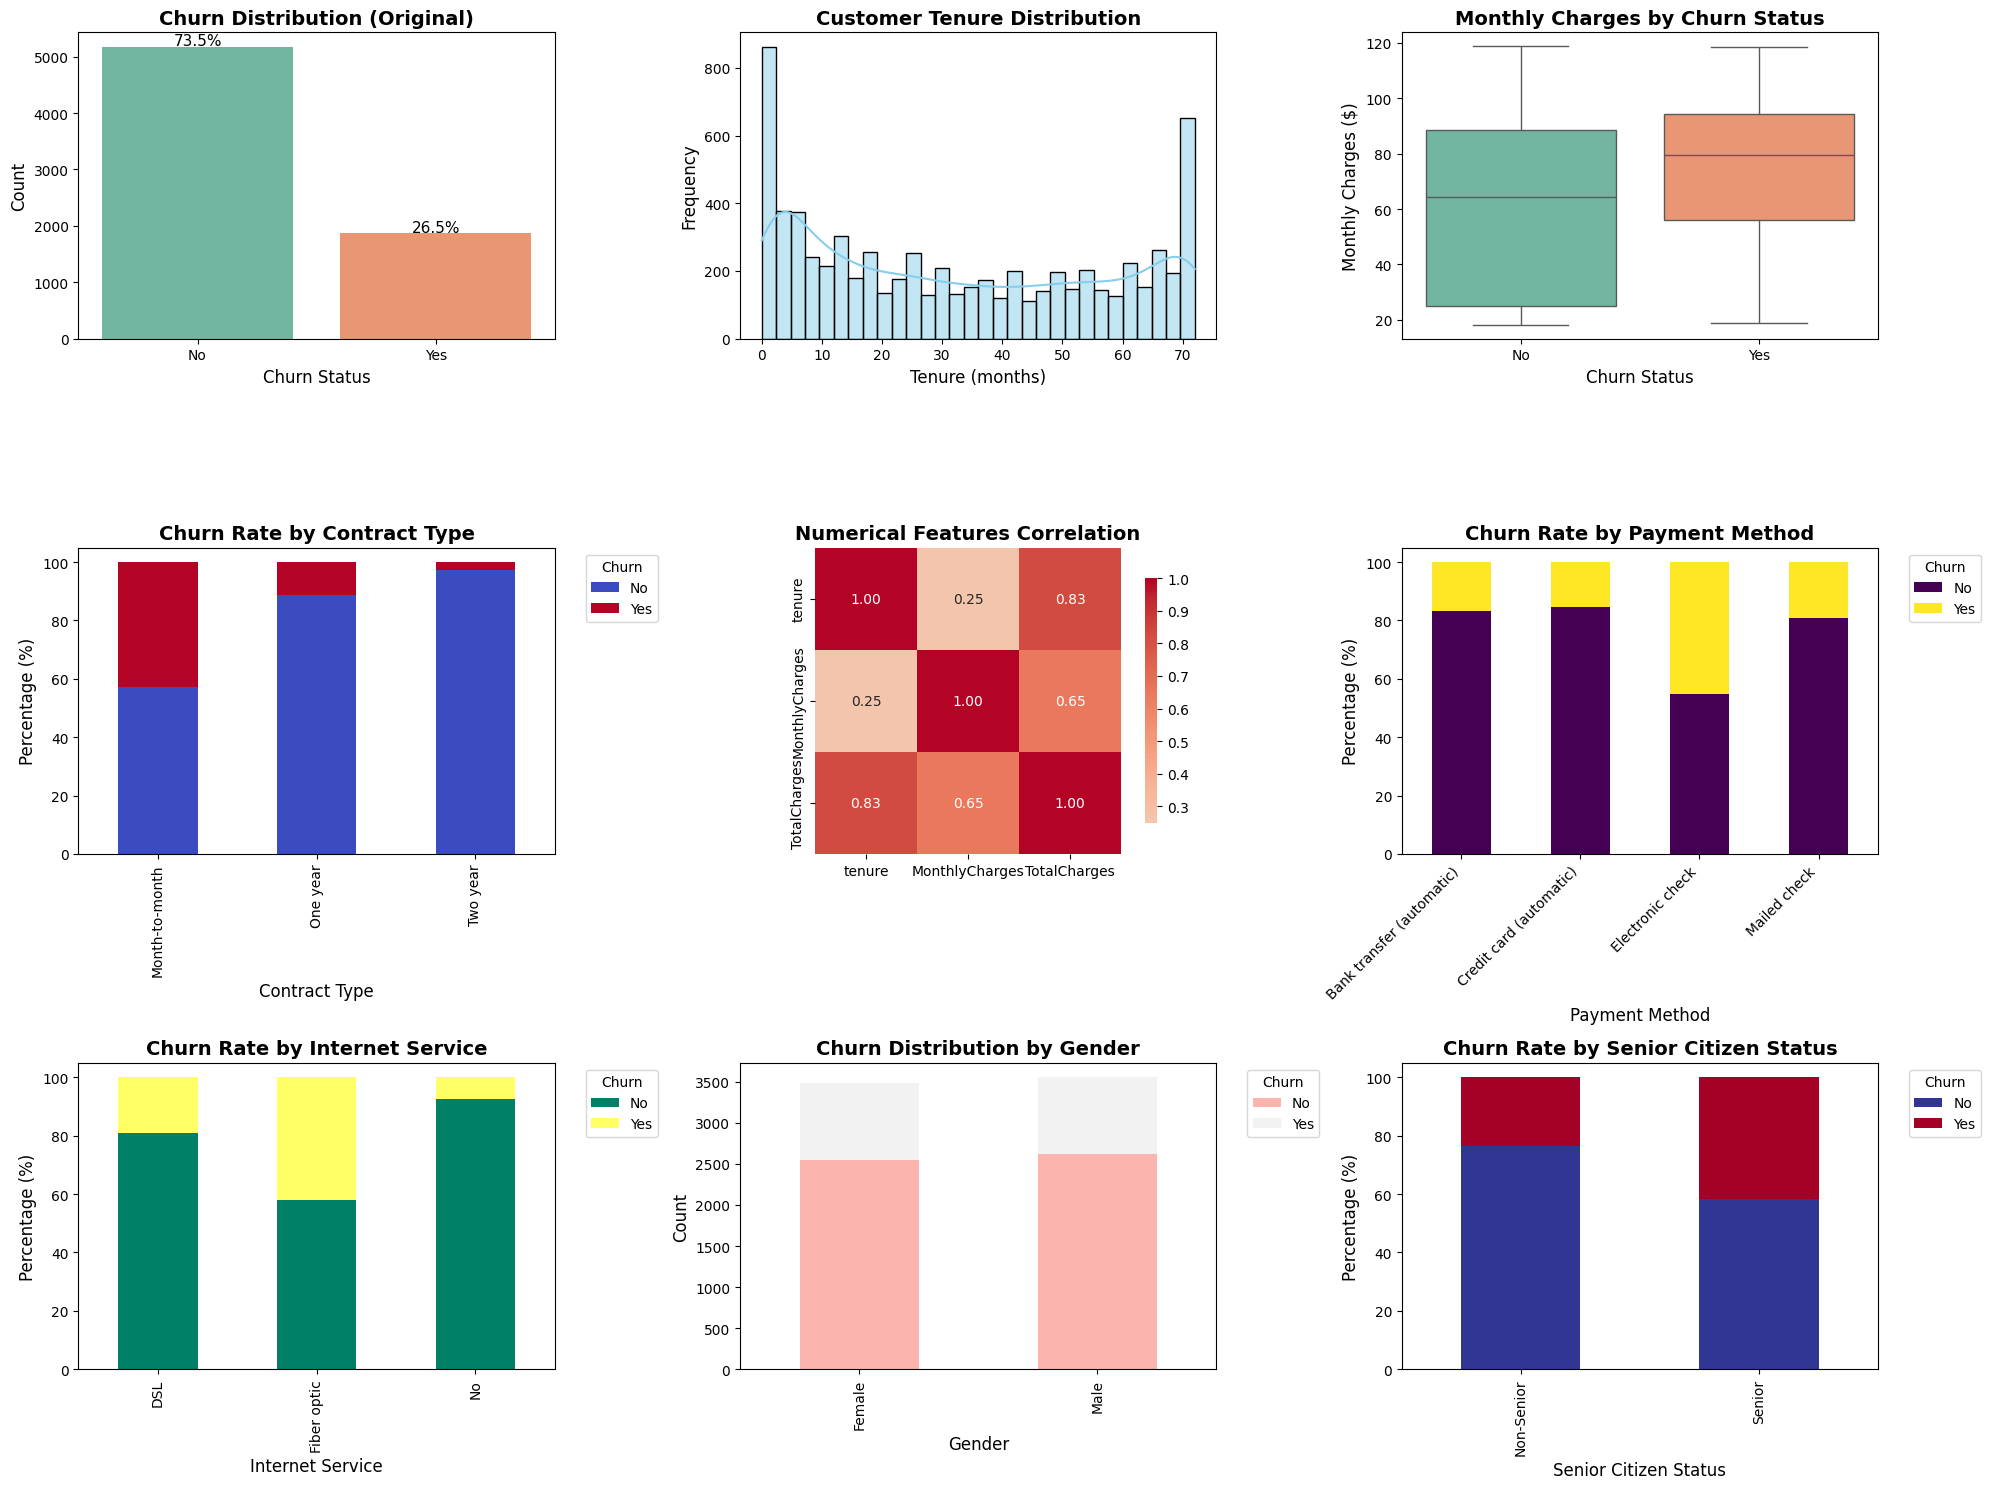

In [14]:
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)

# Define DRIVE_PATH for saving visualizations
DRIVE_PATH = './colab_output'
os.makedirs(DRIVE_PATH, exist_ok=True)

# 2.1 Basic information
print("\n2.1 DATASET INFORMATION:")
print(f"   Total samples: {len(df)}")
print(f"   Total features: {len(df.columns)}")

# Data types
print("\n2.2 DATA TYPES:")
print(df.dtypes)

# Missing values
print("\n2.3 MISSING VALUES:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 2.4 Class Distribution - BEFORE BALANCING
print("\n2.4 CLASS DISTRIBUTION (BEFORE BALANCING):")
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print(f"   No Churn:  {churn_counts['No']} ({churn_percent['No']:.1f}%)")
print(f"   Churn:     {churn_counts['Yes']} ({churn_percent['Yes']:.1f}%)")
print(f"   IMBALANCE RATIO: {churn_counts['No']/churn_counts['Yes']:.2f}:1")

# Save for report
class_dist_before = {
    'No': churn_counts['No'],
    'Yes': churn_counts['Yes'],
    'No_percent': churn_percent['No'],
    'Yes_percent': churn_percent['Yes']
}

# 2.5 Numerical features statistics
print("\n2.5 NUMERICAL FEATURES STATISTICS:")
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(df[numerical_cols].describe())

# 2.6 Visualizations
print("\n2.6 CREATING EDA VISUALIZATIONS...")
plt.figure(figsize=(20, 15))

# Subplot 1: Churn distribution
plt.subplot(3, 3, 1)
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Churn Distribution (Original)', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Churn Status', fontsize=12)

# Add percentage labels
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height + 30,
                  f'{height/total*100:.1f}%', ha='center', fontsize=11)

# Subplot 2: Tenure distribution
plt.subplot(3, 3, 2)
sns.histplot(df['tenure'], bins=30, kde=True, color='skyblue')
plt.title('Customer Tenure Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Subplot 3: Monthly charges vs Churn
plt.subplot(3, 3, 3)
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Set2')
plt.title('Monthly Charges by Churn Status', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Monthly Charges ($)', fontsize=12)

# Subplot 4: Contract type impact
plt.subplot(3, 3, 4)
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
contract_churn.plot(kind='bar', stacked=True, colormap='coolwarm', ax=plt.gca())
plt.title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Contract Type', fontsize=12)
plt.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 5: Correlation heatmap
plt.subplot(3, 3, 5)
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Numerical Features Correlation', fontsize=14, fontweight='bold')

# Subplot 6: Payment method impact
plt.subplot(3, 3, 6)
payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
payment_churn.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Churn Rate by Payment Method', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Payment Method', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 7: Internet service impact
plt.subplot(3, 3, 7)
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
internet_churn.plot(kind='bar', stacked=True, colormap='summer', ax=plt.gca())
plt.title('Churn Rate by Internet Service', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Internet Service', fontsize=12)
plt.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 8: Gender distribution
plt.subplot(3, 3, 8)
gender_churn = pd.crosstab(df['gender'], df['Churn'])
gender_churn.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())
plt.title('Churn Distribution by Gender', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 9: Senior citizen impact
plt.subplot(3, 3, 9)
senior_churn = pd.crosstab(df['SeniorCitizen'], df['Churn'], normalize='index') * 100
senior_churn.index = ['Non-Senior', 'Senior']
senior_churn.plot(kind='bar', stacked=True, colormap='RdYlBu_r', ax=plt.gca())
plt.title('Churn Rate by Senior Citizen Status', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Senior Citizen Status', fontsize=12)
plt.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
eda_path = os.path.join(DRIVE_PATH, 'eda_visualizations.png')
plt.savefig(eda_path, dpi=300, bbox_inches='tight')
print(f"\n EDA visualizations saved as '{eda_path}'")

# Show EDA insights
print("\n" + "="*60)
print("KEY EDA INSIGHTS:")
print("="*60)
print("1. Class Imbalance: Significant imbalance (73% No Churn vs 27% Churn)")
print("2. Monthly Charges: Churned customers tend to have higher monthly charges")
print("3. Contract Type: Month-to-month contracts have highest churn rate")
print("4. Tenure: Long-term customers less likely to churn")
print("5. Payment Method: Electronic check has highest churn rate")
print("6. Internet Service: Fiber optic customers more likely to churn")
print("7. Senior Citizens: Slightly higher churn rate among seniors")

print("\n EDA completed!")

#DATA PREPROCESSING & FEATURE ENGINEERING

In [15]:
print("\n" + "="*60)
print("DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*60)

# 3.1 Encode categorical variables
print("\n3.1 ENCODING CATEGORICAL VARIABLES...")

# Binary encoding for Yes/No columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Label encoding for other categoricals
label_encoders = {}
categorical_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies', 'Contract', 'PaymentMethod']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Target encoding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print(f"   Encoded {len(binary_cols) + len(categorical_cols)} categorical features")

# 3.2 Feature selection
print("\n3.2 SELECTING FEATURES...")
# Drop customerID
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

print(f"   Features selected: {X.shape[1]}")
print(f"   Feature names: {X.columns.tolist()}")

# 3.3 Train-test split (BEFORE SMOTE to avoid data leakage)
print("\n3.3 TRAIN-TEST SPLIT (80-20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"   Training set: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test set:     {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

# Check class distribution in train/test
print(f"\n   Class distribution in Training set:")
train_counts = y_train.value_counts()
for val, count in train_counts.items():
    label = "Churn" if val == 1 else "No Churn"
    print(f"     {label}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\n   Class distribution in Test set:")
test_counts = y_test.value_counts()
for val, count in test_counts.items():
    label = "Churn" if val == 1 else "No Churn"
    print(f"     {label}: {count} ({count/len(y_test)*100:.1f}%)")

# 3.4 Feature scaling
print("\n3.4 SCALING FEATURES...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("   Features scaled using StandardScaler")

print("\n Data preprocessing completed!")


DATA PREPROCESSING & FEATURE ENGINEERING

3.1 ENCODING CATEGORICAL VARIABLES...
   Encoded 15 categorical features

3.2 SELECTING FEATURES...
   Features selected: 19
   Feature names: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

3.3 TRAIN-TEST SPLIT (80-20)...
   Training set: (5634, 19) (80.0%)
   Test set:     (1409, 19) (20.0%)

   Class distribution in Training set:
     No Churn: 4139 (73.5%)
     Churn: 1495 (26.5%)

   Class distribution in Test set:
     No Churn: 1035 (73.5%)
     Churn: 374 (26.5%)

3.4 SCALING FEATURES...
   Features scaled using StandardScaler

 Data preprocessing completed!


#HANDLING CLASS IMBALANCE WITH SMOTE


HANDLING CLASS IMBALANCE WITH SMOTE

4.1 CLASS DISTRIBUTION BEFORE SMOTE (Training set):
   No Churn: 4139 (73.5%)
   Churn: 1495 (26.5%)

4.2 APPLYING SMOTE TO TRAINING DATA...
4.3 CLASS DISTRIBUTION AFTER SMOTE:
   No Churn: 4139 (50.0%)
   Churn: 4139 (50.0%)

 SMOTE comparison visualization saved as './colab_output/smote_comparison.png'

 SMOTE applied successfully. Training data is now balanced.


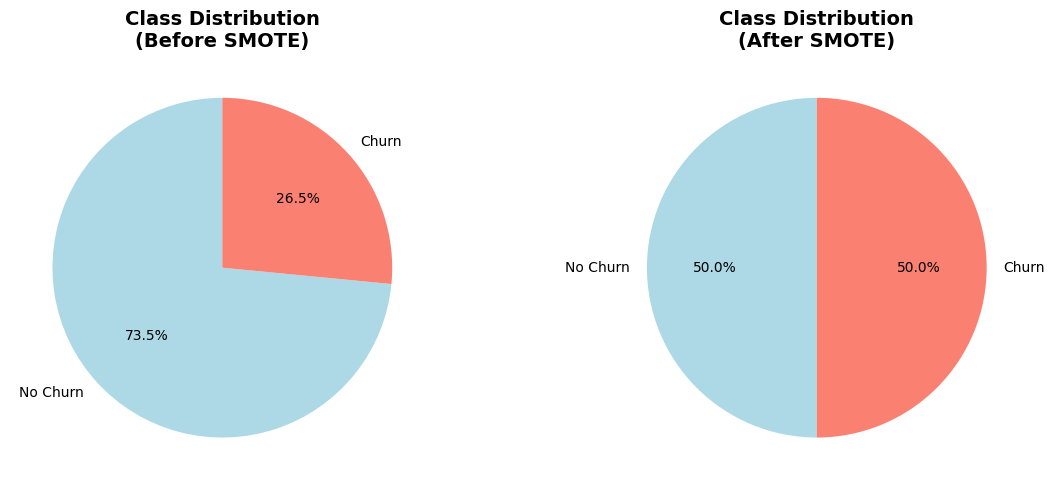

In [16]:
print("\n" + "="*60)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*60)

# Define DRIVE_PATH for saving visualizations
DRIVE_PATH = './colab_output' # Local directory for demonstration
os.makedirs(DRIVE_PATH, exist_ok=True)

# 4.1 Check class distribution BEFORE SMOTE
print("\n4.1 CLASS DISTRIBUTION BEFORE SMOTE (Training set):")
unique_before, counts_before = np.unique(y_train, return_counts=True)
for val, count in zip(unique_before, counts_before):
    percentage = count / len(y_train) * 100
    label = "Churn" if val == 1 else "No Churn"
    print(f"   {label}: {count} ({percentage:.1f}%)")

# 4.2 Apply SMOTE ONLY to training data
print("\n4.2 APPLYING SMOTE TO TRAINING DATA...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 4.3 Check class distribution AFTER SMOTE
print("4.3 CLASS DISTRIBUTION AFTER SMOTE:")
unique_after, counts_after = np.unique(y_train_bal, return_counts=True)
for val, count in zip(unique_after, counts_after):
    percentage = count / len(y_train_bal) * 100
    label = "Churn" if val == 1 else "No Churn"
    print(f"   {label}: {count} ({percentage:.1f}%)")

class_dist_after = {
    'No': counts_after[0],
    'Yes': counts_after[1],
    'No_percent': counts_after[0]/len(y_train_bal)*100,
    'Yes_percent': counts_after[1]/len(y_train_bal)*100
}

# 4.4 Visualize before/after SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
labels = ['No Churn', 'Churn']
colors = ['lightblue', 'salmon']
plt.pie(counts_before, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution\n(Before SMOTE)', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(counts_after, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution\n(After SMOTE)', fontsize=14, fontweight='bold')

plt.tight_layout()
smote_path = os.path.join(DRIVE_PATH, 'smote_comparison.png')
plt.savefig(smote_path, dpi=300, bbox_inches='tight')
print(f"\n SMOTE comparison visualization saved as '{smote_path}'")

print("\n SMOTE applied successfully. Training data is now balanced.")

#DECISION TREE MODEL


DECISION TREE MODEL

5.1 PERFORMING HYPERPARAMETER TUNING...
   This may take a few minutes...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits

 Hyperparameter tuning completed!
   Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 30}
   Best CV F1-score: 0.7916

5.2 TRAINING FINAL DECISION TREE...
   Model training completed!

5.3 FEATURE IMPORTANCE ANALYSIS...

   Top 10 Most Important Features:
         feature  importance
     TechSupport    0.385992
    TotalCharges    0.115065
   PaymentMethod    0.100818
  OnlineSecurity    0.087673
        Contract    0.068531
PaperlessBilling    0.062206
 InternetService    0.061357
          tenure    0.059881
  MonthlyCharges    0.021130
DeviceProtection    0.011422


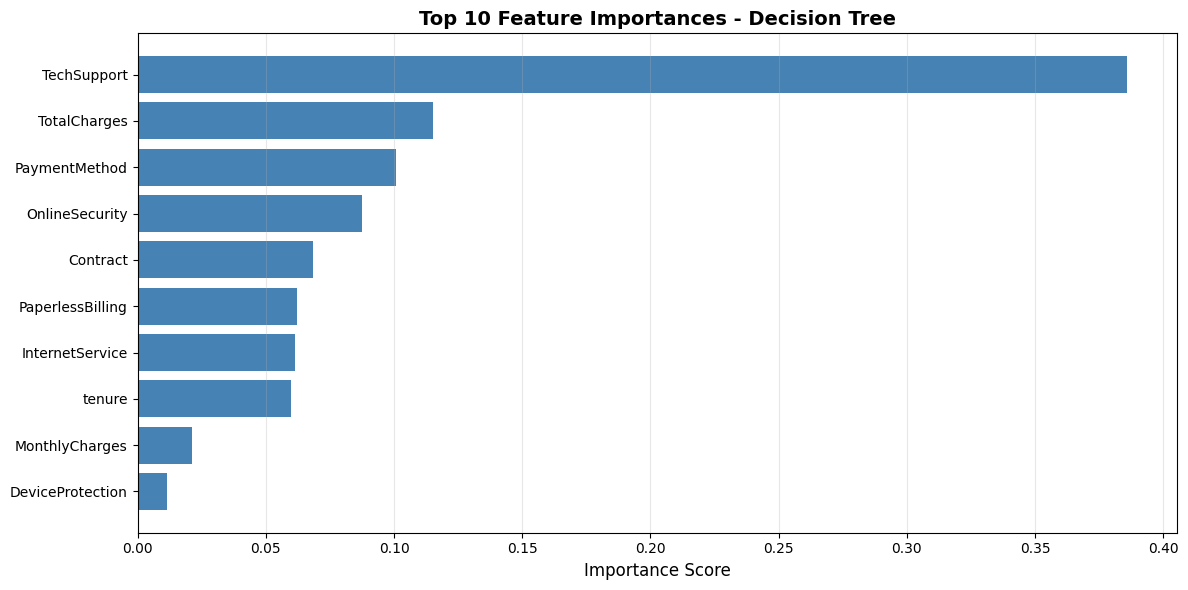

   Feature importance chart saved as 'decision_tree_feature_importance.png'

5.4 MAKING PREDICTIONS...

5.5 EVALUATING DECISION TREE...
    Accuracy:  0.7459
    Precision: 0.5148
    Recall:    0.7433
    F1-Score:  0.6083
    AUC:       0.8089

   Confusion Matrix:
   [[TN: 773, FP: 262]
    [FN: 96, TP: 278]]

Decision Tree model completed!


In [17]:
print("\n" + "="*60)
print("DECISION TREE MODEL")
print("="*60)

# 5.1 Hyperparameter tuning with GridSearchCV
print("\n5.1 PERFORMING HYPERPARAMETER TUNING...")
print("   This may take a few minutes...")

dt_model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [5, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    dt_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_bal, y_train_bal)

best_dt = grid_search.best_estimator_
print(f"\n Hyperparameter tuning completed!")
print(f"   Best parameters: {grid_search.best_params_}")
print(f"   Best CV F1-score: {grid_search.best_score_:.4f}")

# 5.2 Train final model
print("\n5.2 TRAINING FINAL DECISION TREE...")
best_dt.fit(X_train_bal, y_train_bal)
print("   Model training completed!")

# ===== ADD FEATURE IMPORTANCE ANALYSIS =====
print("\n5.3 FEATURE IMPORTANCE ANALYSIS...")

# Get feature importance
dt_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\n   Top 10 Most Important Features:")
print(dt_importance.head(10).to_string(index=False))

# Create horizontal bar chart for top 10 features
plt.figure(figsize=(12, 6))
plt.barh(dt_importance['feature'].head(10)[::-1],
         dt_importance['importance'].head(10)[::-1],
         color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Feature Importances - Decision Tree',
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('decision_tree_feature_importance.png', dpi=300)
plt.show()

print("   Feature importance chart saved as 'decision_tree_feature_importance.png'")

# 5.4 Predictions
print("\n5.4 MAKING PREDICTIONS...")
y_pred_dt = best_dt.predict(X_test_scaled)
y_pred_proba_dt = best_dt.predict_proba(X_test_scaled)[:, 1]

# 5.5 Evaluation
print("\n5.5 EVALUATING DECISION TREE...")
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_pred_proba_dt)

print(f"    Accuracy:  {dt_accuracy:.4f}")
print(f"    Precision: {dt_precision:.4f}")
print(f"    Recall:    {dt_recall:.4f}")
print(f"    F1-Score:  {dt_f1:.4f}")
print(f"    AUC:       {dt_auc:.4f}")

# 5.6 Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(f"\n   Confusion Matrix:")
print(f"   [[TN: {cm_dt[0,0]}, FP: {cm_dt[0,1]}]")
print(f"    [FN: {cm_dt[1,0]}, TP: {cm_dt[1,1]}]]")

print("\n" + "="*60)
print("Decision Tree model completed!")
print("="*60)

#NEURAL NETWORK MODEL

In [18]:
print("\n" + "="*60)
print("NEURAL NETWORK MODEL WITH FAST HYPERPARAMETER TUNING")
print("="*60)

def build_model(hp):
    """Function to build model with hyperparameters"""
    model = keras.Sequential()

    # Layer 1 (tune units)
    model.add(layers.Dense(
        units=hp.Int('units_1', 64, 128, step=32),
        activation='relu',
        input_shape=(X_train_bal.shape[1],)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(
        hp.Float('dropout_1', 0.3, 0.5, step=0.1)
    ))

    # Layer 2
    model.add(layers.Dense(
        units=hp.Int('units_2', 32, 64, step=16),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(
        hp.Float('dropout_2', 0.2, 0.4, step=0.1)
    ))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')

    # Fixed to Adam only
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='telco_churn_fast_tuning',
    overwrite=True
)

# Display search space
print("\n   Fast Hyperparameter Search Space:")
print("   • Layer 1 units: 64, 96, 128")
print("   • Layer 1 dropout: 0.3, 0.4, 0.5")
print("   • Layer 2 units: 32, 48, 64")
print("   • Layer 2 dropout: 0.2, 0.3, 0.4")
print("   • Learning rate: 0.0001-0.001")
print("   • Total trials: 6 (fast)")
print("   • Epochs per trial: 30")

#VALIDATION SET FOR SPEED
from sklearn.model_selection import train_test_split
X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X_train_bal, y_train_bal,
    test_size=0.1,
    random_state=42
)

# Perform the hyperparameter search
tuner.search(
    X_train_tune, y_train_tune,
    epochs=30,
    validation_data=(X_val_tune, y_val_tune),
    batch_size=32,
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=0
        )
    ],
    verbose=0
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\n   BEST HYPERPARAMETERS FOUND (FAST TUNING):")
print(f"   • Layer 1 units: {best_hps.get('units_1')}")
print(f"   • Layer 1 dropout: {best_hps.get('dropout_1'):.3f}")
print(f"   • Layer 2 units: {best_hps.get('units_2')}")
print(f"   • Layer 2 dropout: {best_hps.get('dropout_2'):.3f}")
print(f"   • Learning rate: {best_hps.get('learning_rate'):.6f}")

# Get best trial score
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"   • Best validation accuracy: {best_trial.score:.4f}")

# Build the model with hyperparameters
nn_model = tuner.hypermodel.build(best_hps)

# Display model summary
print("   Final Model Architecture:")
nn_model.summary()



print("\n COMPILING FINAL MODEL WITH FULL METRICS...")

# Recompile with your original metrics
learning_rate = best_hps.get('learning_rate')
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print(f"    Model compiled with Adam optimizer (learning_rate={learning_rate:.6f})")


# 6.3 CALLBACKS
print("\n6.4 SETTING UP CALLBACKS...")
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


# 6.4 TRAIN THE FINAL MODEL
print("\n6.4 TRAINING FINAL NEURAL NETWORK...")

history = nn_model.fit(
    X_train_bal, y_train_bal,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

print(f"\n   Training completed!")
print(f"   Final epoch: {len(history.history['loss'])}")

# 6.5 PREDICTIONS
print("\n6.5 MAKING PREDICTIONS...")
y_pred_proba_nn = nn_model.predict(X_test_scaled, verbose=0)
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)


# 6.6 EVALUATION
print("\n6.6 EVALUATING NEURAL NETWORK...")
nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_precision = precision_score(y_test, y_pred_nn)
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)
nn_auc = roc_auc_score(y_test, y_pred_proba_nn)

print(f"   Accuracy:  {nn_accuracy:.4f}")
print(f"   Precision: {nn_precision:.4f}")
print(f"   Recall:    {nn_recall:.4f}")
print(f"   F1-Score:  {nn_f1:.4f}")
print(f"   AUC:       {nn_auc:.4f}")


# 6.7 CONFUSION MATRIX
cm_nn = confusion_matrix(y_test, y_pred_nn)
print(f"\n   Confusion Matrix:")
print(f"   [[TN: {cm_nn[0,0]}, FP: {cm_nn[0,1]}]")
print(f"    [FN: {cm_nn[1,0]}, TP: {cm_nn[1,1]}]]")


# 6.8 SAVE TUNING RESULTS
print("\n6.8 SAVING TUNING RESULTS...")
import json

# Save best hyperparameters
best_params = best_hps.values
with open('best_hyperparameters_fast.json', 'w') as f:
    json.dump(best_params, f, indent=2)

# Quick tuning summary
tuning_summary = {
    'best_validation_accuracy': float(best_trial.score),
    'total_trials_completed': len(tuner.oracle.trials),
    'tuning_time_estimate': '2-3 minutes',
    'best_hyperparameters': best_params
}

with open('tuning_summary_fast.json', 'w') as f:
    json.dump(tuning_summary, f, indent=2)

print(f"\n   Tuning results saved to:")
print(f"   • best_hyperparameters_fast.json")
print(f"   • tuning_summary_fast.json")

print("\n" + "="*60)
print("Neural Network with fast hyperparameter tuning completed!")
print("Total tuning + training time: ~3-4 minutes")
print("="*60)


NEURAL NETWORK MODEL WITH FAST HYPERPARAMETER TUNING

   Fast Hyperparameter Search Space:
   • Layer 1 units: 64, 96, 128
   • Layer 1 dropout: 0.3, 0.4, 0.5
   • Layer 2 units: 32, 48, 64
   • Layer 2 dropout: 0.2, 0.3, 0.4
   • Learning rate: 0.0001-0.001
   • Total trials: 6 (fast)
   • Epochs per trial: 30

   BEST HYPERPARAMETERS FOUND (FAST TUNING):
   • Layer 1 units: 128
   • Layer 1 dropout: 0.300
   • Layer 2 units: 32
   • Layer 2 dropout: 0.400
   • Learning rate: 0.000589
   • Best validation accuracy: 0.8019
   Final Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,041 (27.50 KB)

 Non-trainable params: 320 (1.25 KB)


 COMPILING FINAL MODEL WITH FULL METRICS...
    Model compiled with Adam optimizer (learning_rate=0.000589)

6.4 SETTING UP CALLBACKS...

6.4 TRAINING FINAL NEURAL NETWORK...
Epoch 1/80
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6375 - auc: 0.6936 - loss: 0.7534 - precision: 0.5103 - recall: 0.6684 - val_accuracy: 0.7868 - val_auc: 0.0000e+00 - val_loss: 0.4655 - val_precision: 1.0000 - val_recall: 0.7868 - learning_rate: 5.8891e-04
Epoch 2/80
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7184 - auc: 0.7845 - loss: 0.5843 - precision: 0.6079 - recall: 0.6787 - val_accuracy: 0.7524 - val_auc: 0.0000e+00 - val_loss: 0.5096 - val_precision: 1.0000 - val_recall: 0.7524 - learning_rate: 5.8891e-04
Epoch 3/80
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7406 - auc: 0.7981 - loss: 0.5477 - precision: 0.6447 - recall: 0.6696 - val_accuracy: 0.7524 - val_auc: 0.0000e+00 - val_loss: 0.5297 - val_precision: 1.0000 - val_recall: 0.7524 - learning_rate: 5.8891e-04
E

#MODEL COMPARISON, VISUALIZATION & FINAL OUTPUT


MODEL COMPARISON AND RESULTS

   Performing cross-validation for Neural Network...

MODEL PERFORMANCE COMPARISON:
--------------------------------------------------------------------------------
         Model  CV Mean F1  CV Std F1  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  Train F1  Test F1  Test AUC-ROC  Test Average Precision  Accuracy Gap  F1 Gap
 Decision Tree      0.7916     0.0212          0.7892         0.7459           0.7698          0.5148        0.8251       0.7433    0.7965   0.6083        0.8089                  0.5775        0.0433  0.1882
Neural Network      0.8261     0.0410          0.7754         0.7381           0.7078          0.5044        0.6830       0.7594    0.7732   0.6062        0.8210                  0.5954        0.0373  0.1670

7.2 BEST MODEL SELECTION:

 BEST PERFORMING MODEL: Decision Tree
   Test F1 Score: 0.6083
   Test Accuracy: 0.7459
   Best AUC-ROC: Neural Network (0.8210)
   Best Average Precisi


 Model comparison visualizations saved as './colab_output/model_comparison_results.png'

DETAILED CLASSIFICATION REPORTS

1. DECISION TREE CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.89      0.75      0.81      1035
       Churn       0.51      0.74      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409


2. NEURAL NETWORK CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

    No Churn       0.89      0.73      0.80      1035
       Churn       0.50      0.76      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.74      0.75      1409


3. CONFUSION MATRI

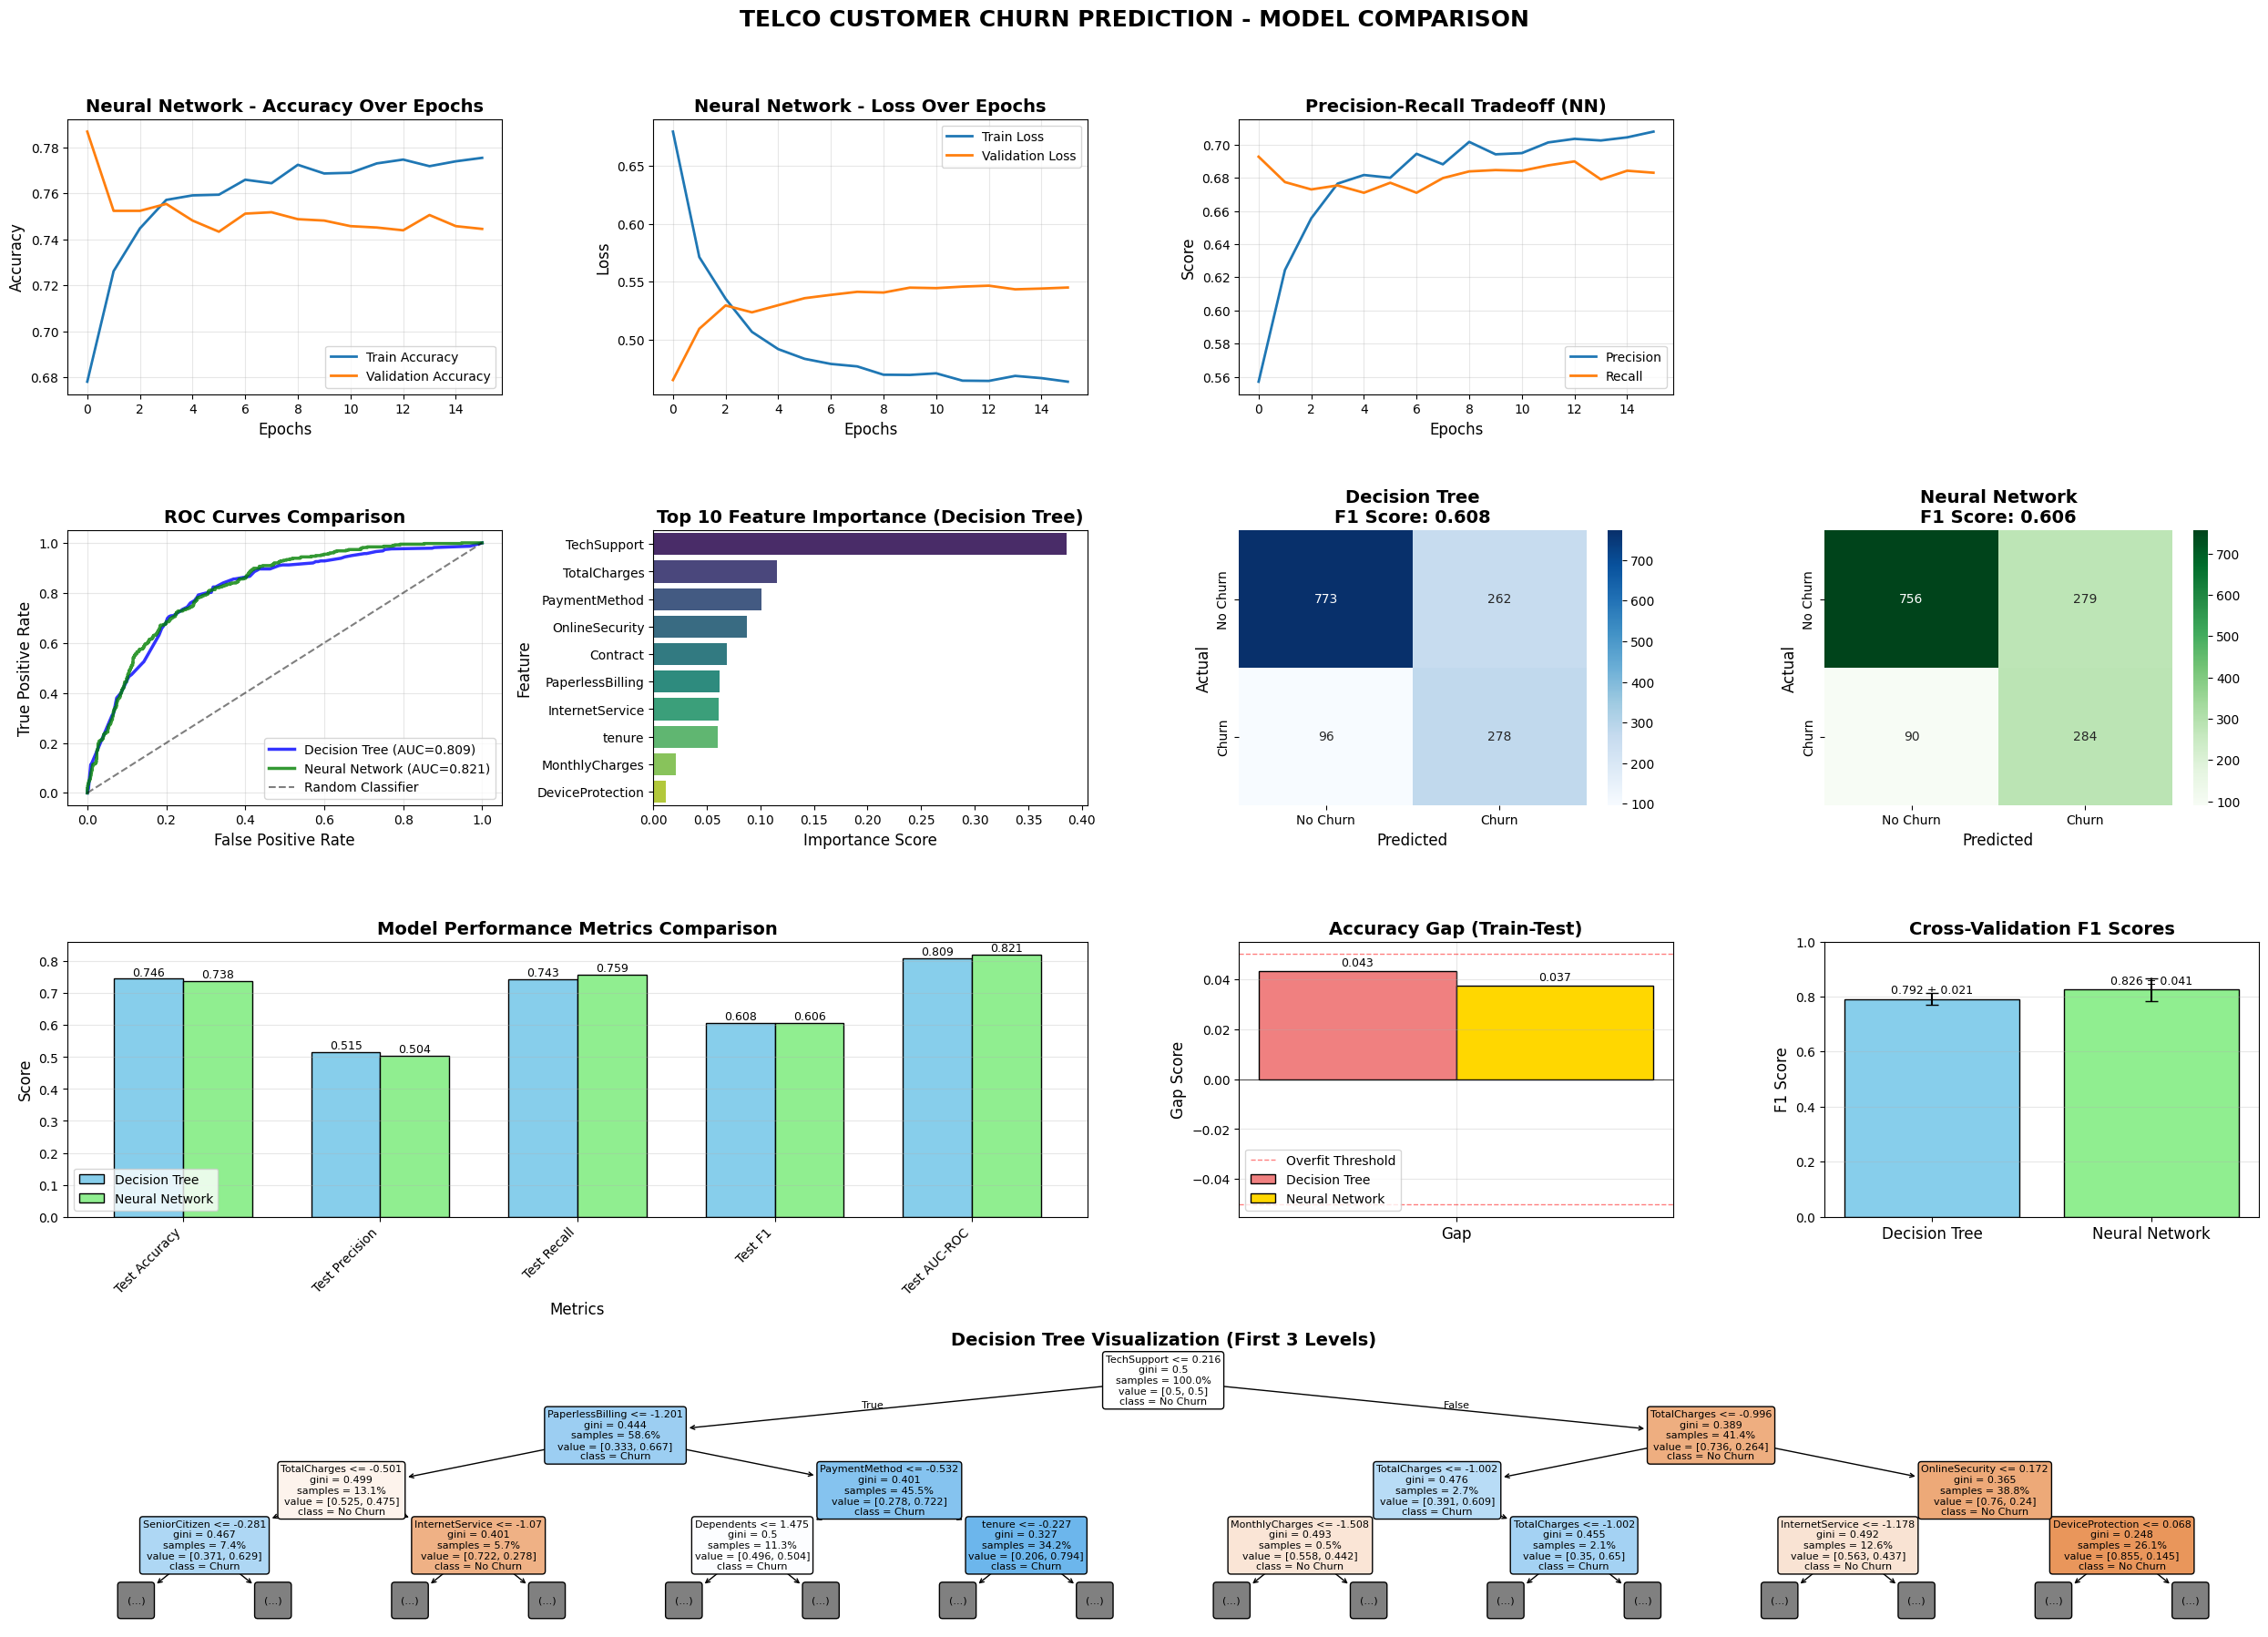

In [19]:
print("\n" + "="*70)
print("MODEL COMPARISON AND RESULTS")
print("="*70)

# Collect metrics for comprehensive comparison
print("\nCollecting model metrics for comparison...")

# Calculate additional metrics for both models
# 1. Calculate CV scores for Decision Tree
cv_scores_dt = grid_search.cv_results_['mean_test_score']
cv_mean_f1_dt = grid_search.best_score_
cv_std_f1_dt = cv_scores_dt.std()

# 2. Calculate training metrics for Decision Tree
y_train_pred_dt = best_dt.predict(X_train_bal)
train_accuracy_dt = accuracy_score(y_train_bal, y_train_pred_dt)
train_precision_dt = precision_score(y_train_bal, y_train_pred_dt)
train_recall_dt = recall_score(y_train_bal, y_train_pred_dt)
train_f1_dt = f1_score(y_train_bal, y_train_pred_dt)

# Calculate test average precision for Decision Tree
from sklearn.metrics import average_precision_score
test_avg_precision_dt = average_precision_score(y_test, y_pred_proba_dt)

# 3. Calculate training metrics for Neural Network
y_train_pred_nn = (nn_model.predict(X_train_bal, verbose=0) > 0.5).astype(int)
train_accuracy_nn = history.history['accuracy'][-1] if len(history.history['accuracy']) > 0 else accuracy_score(y_train_bal, y_train_pred_nn)
train_precision_nn = history.history['precision'][-1] if 'precision' in history.history else precision_score(y_train_bal, y_train_pred_nn)
train_recall_nn = history.history['recall'][-1] if 'recall' in history.history else recall_score(y_train_bal, y_train_pred_nn)
train_f1_nn = history.history.get('f1', [f1_score(y_train_bal, y_train_pred_nn)])[-1]

# 4. Calculate CV scores for Neural Network (using simple cross-validation)
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Create a simpler NN for cross-validation (to save time)
simple_nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=32,
    max_iter=100,
    random_state=42
)

# Perform cross-validation on balanced data
print("   Performing cross-validation for Neural Network...")
cv_scores_nn = cross_val_score(simple_nn, X_train_bal, y_train_bal,
                               cv=5, scoring='f1', n_jobs=-1)
cv_mean_f1_nn = cv_scores_nn.mean()
cv_std_f1_nn = cv_scores_nn.std()

# Calculate test average precision for Neural Network
test_avg_precision_nn = average_precision_score(y_test, y_pred_proba_nn)

# Calculate gaps
accuracy_gap_dt = train_accuracy_dt - dt_accuracy
f1_gap_dt = train_f1_dt - dt_f1

accuracy_gap_nn = train_accuracy_nn - nn_accuracy
f1_gap_nn = train_f1_nn - nn_f1

# Create comprehensive metrics dictionaries
dt_metrics = {
    'Model': 'Decision Tree',
    'CV Mean F1': cv_mean_f1_dt,
    'CV Std F1': cv_std_f1_dt,
    'Train Accuracy': train_accuracy_dt,
    'Test Accuracy': dt_accuracy,
    'Train Precision': train_precision_dt,
    'Test Precision': dt_precision,
    'Train Recall': train_recall_dt,
    'Test Recall': dt_recall,
    'Train F1': train_f1_dt,
    'Test F1': dt_f1,
    'Test AUC-ROC': dt_auc,
    'Test Average Precision': test_avg_precision_dt,
    'Accuracy Gap': accuracy_gap_dt,
    'F1 Gap': f1_gap_dt
}

nn_metrics = {
    'Model': 'Neural Network',
    'CV Mean F1': cv_mean_f1_nn,
    'CV Std F1': cv_std_f1_nn,
    'Train Accuracy': train_accuracy_nn,
    'Test Accuracy': nn_accuracy,
    'Train Precision': train_precision_nn,
    'Test Precision': nn_precision,
    'Train Recall': train_recall_nn,
    'Test Recall': nn_recall,
    'Train F1': train_f1_nn,
    'Test F1': nn_f1,
    'Test AUC-ROC': nn_auc,
    'Test Average Precision': test_avg_precision_nn,
    'Accuracy Gap': accuracy_gap_nn,
    'F1 Gap': f1_gap_nn
}

# Create comparison dataframe
all_metrics = [dt_metrics, nn_metrics]
metrics_df = pd.DataFrame(all_metrics)

# Round all numeric columns to 4 decimal places
numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns
metrics_df[numeric_cols] = metrics_df[numeric_cols].round(4)

# 7.1 Performance comparison dataframe
print("\nMODEL PERFORMANCE COMPARISON:")
print("-" * 80)

# Reorder columns to match the desired format
column_order = [
    'Model', 'CV Mean F1', 'CV Std F1',
    'Train Accuracy', 'Test Accuracy',
    'Train Precision', 'Test Precision',
    'Train Recall', 'Test Recall',
    'Train F1', 'Test F1',
    'Test AUC-ROC', 'Test Average Precision',
    'Accuracy Gap', 'F1 Gap'
]

metrics_df = metrics_df[column_order]
print(metrics_df.to_string(index=False))

# 7.2 Determine best model
print("\n7.2 BEST MODEL SELECTION:")
# Find best model based on Test F1-Score
best_overall_idx = metrics_df['Test F1'].idxmax()
best_model_name = metrics_df.loc[best_overall_idx, 'Model']
best_test_f1 = metrics_df.loc[best_overall_idx, 'Test F1']
best_test_acc = metrics_df.loc[best_overall_idx, 'Test Accuracy']

print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"   Test F1 Score: {best_test_f1:.4f}")
print(f"   Test Accuracy: {best_test_acc:.4f}")

# Also show which model has better AUC-ROC
best_auc_idx = metrics_df['Test AUC-ROC'].idxmax()
best_auc_model = metrics_df.loc[best_auc_idx, 'Model']
best_auc = metrics_df.loc[best_auc_idx, 'Test AUC-ROC']
print(f"   Best AUC-ROC: {best_auc_model} ({best_auc:.4f})")

# Show which model has better Average Precision
best_ap_idx = metrics_df['Test Average Precision'].idxmax()
best_ap_model = metrics_df.loc[best_ap_idx, 'Model']
best_ap = metrics_df.loc[best_ap_idx, 'Test Average Precision']
print(f"   Best Average Precision: {best_ap_model} ({best_ap:.4f})")

# 7.3 Visualizations - Updated with cleaner layout
print("\n7.3 CREATING COMPREHENSIVE VISUALIZATIONS...")

# Main comparison figure
fig = plt.figure(figsize=(25, 22))
fig.suptitle('TELCO CUSTOMER CHURN PREDICTION - MODEL COMPARISON',
             fontsize=18, fontweight='bold', y=1.02)

# ========== ROW 1: Training History ==========
# Subplot 1: Training history - Accuracy
ax1 = plt.subplot(5, 4, 1)
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Neural Network - Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Training history - Loss
ax2 = plt.subplot(5, 4, 2)
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Neural Network - Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Subplot 3: Precision-Recall Tradeoff
ax3 = plt.subplot(5, 4, 3)
ax3.plot(history.history['precision'], label='Precision', linewidth=2)
ax3.plot(history.history['recall'], label='Recall', linewidth=2)
ax3.set_title('Precision-Recall Tradeoff (NN)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epochs', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)



# ========== ROW 2: ROC Curves & Feature Importance ==========
# Subplot 5: ROC Curves Comparison
ax5 = plt.subplot(5, 4, 5)
# DT ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
ax5.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_auc:.3f})',
         linewidth=2.5, color='blue', alpha=0.8)
# NN ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
ax5.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC={nn_auc:.3f})',
         linewidth=2.5, color='green', alpha=0.8)
ax5.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
ax5.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax5.set_xlabel('False Positive Rate', fontsize=12)
ax5.set_ylabel('True Positive Rate', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Subplot 6: Feature Importance
ax6 = plt.subplot(5, 4, 6)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False).head(10)
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis', ax=ax6)
ax6.set_title('Top 10 Feature Importance (Decision Tree)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Importance Score', fontsize=12)
ax6.set_ylabel('Feature', fontsize=12)

# ========== ROW 3: Confusion Matrices ==========
# Subplot 7: Decision Tree Confusion Matrix
ax7 = plt.subplot(5, 4, 7)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=ax7,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
ax7.set_title(f'Decision Tree\nF1 Score: {dt_f1:.3f}', fontsize=14, fontweight='bold')
ax7.set_ylabel('Actual', fontsize=12)
ax7.set_xlabel('Predicted', fontsize=12)

# Subplot 8: Neural Network Confusion Matrix
ax8 = plt.subplot(5, 4, 8)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', ax=ax8,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
ax8.set_title(f'Neural Network\nF1 Score: {nn_f1:.3f}', fontsize=14, fontweight='bold')
ax8.set_ylabel('Actual', fontsize=12)
ax8.set_xlabel('Predicted', fontsize=12)

# ========== ROW 4: Metrics Comparison ==========
# Subplot 9: Performance Metrics Bar Chart (Enhanced)
ax9 = plt.subplot(5, 4, (9, 10))  # Span 2 columns
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test AUC-ROC']
dt_scores = [dt_accuracy, dt_precision, dt_recall, dt_f1, dt_auc]
nn_scores = [nn_accuracy, nn_precision, nn_recall, nn_f1, nn_auc]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax9.bar(x - width/2, dt_scores, width, label='Decision Tree',
                color='skyblue', edgecolor='black')
bars2 = ax9.bar(x + width/2, nn_scores, width, label='Neural Network',
                color='lightgreen', edgecolor='black')

ax9.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax9.set_xlabel('Metrics', fontsize=12)
ax9.set_ylabel('Score', fontsize=12)
ax9.set_xticks(x)
ax9.set_xticklabels(metrics, rotation=45, ha='right')
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Subplot 10: Accuracy Gap Comparison
ax10 = plt.subplot(5, 4, 11)
gap_metrics = ['Accuracy Gap']
dt_gaps = [accuracy_gap_dt]
nn_gaps = [accuracy_gap_nn]
x_gap = np.arange(len(gap_metrics))
bars_gap1 = ax10.bar(x_gap - width/2, dt_gaps, width, label='Decision Tree',
                     color='lightcoral', edgecolor='black')
bars_gap2 = ax10.bar(x_gap + width/2, nn_gaps, width, label='Neural Network',
                     color='gold', edgecolor='black')

ax10.set_title('Accuracy Gap (Train-Test)', fontsize=14, fontweight='bold')
ax10.set_ylabel('Gap Score', fontsize=12)
ax10.set_xticks(x_gap)
ax10.set_xticklabels(['Gap'], fontsize=12)
ax10.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax10.axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overfit Threshold')
ax10.axhline(y=-0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax10.legend()
ax10.grid(True, alpha=0.3)

# Add value labels for gap bars
for bar, value in zip(bars_gap1 + bars_gap2, dt_gaps + nn_gaps):
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.015),
              f'{height:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# Subplot 11: CV F1 Scores Comparison
ax11 = plt.subplot(5, 4, 12)
models = ['Decision Tree', 'Neural Network']
cv_means = [cv_mean_f1_dt, cv_mean_f1_nn]
cv_stds = [cv_std_f1_dt, cv_std_f1_nn]

x_pos = np.arange(len(models))
bars = ax11.bar(x_pos, cv_means, yerr=cv_stds, capsize=5,
                color=['skyblue', 'lightgreen'], edgecolor='black')
ax11.set_title('Cross-Validation F1 Scores', fontsize=14, fontweight='bold')
ax11.set_ylabel('F1 Score', fontsize=12)
ax11.set_xticks(x_pos)
ax11.set_xticklabels(models, fontsize=12)
ax11.set_ylim([0, 1])
ax11.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mean, std in zip(bars, cv_means, cv_stds):
    height = bar.get_height()
    ax11.text(bar.get_x() + bar.get_width()/2., height + 0.01,
              f'{mean:.3f} ± {std:.3f}', ha='center', va='bottom', fontsize=9)

# ========== ROW 5: Decision Tree Visualization ==========
# Subplot 12: Decision Tree Visualization
ax12 = plt.subplot(5, 4, (13, 16))  # Span 4 columns
plot_tree(best_dt, max_depth=3, feature_names=X.columns,
          class_names=['No Churn', 'Churn'], filled=True, rounded=True,
          proportion=True, fontsize=8, ax=ax12)
ax12.set_title('Decision Tree Visualization (First 3 Levels)', fontsize=14, fontweight='bold')

plt.tight_layout()
comparison_path = os.path.join(DRIVE_PATH, 'model_comparison_results.png')
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
print(f"\n Model comparison visualizations saved as '{comparison_path}'")

# ============================================================================
# DETAILED CLASSIFICATION REPORTS
# ============================================================================

print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 70)

print("\n1. DECISION TREE CLASSIFICATION REPORT:")
print("-" * 60)
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

print("\n2. NEURAL NETWORK CLASSIFICATION REPORT:")
print("-" * 60)
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

# Detailed confusion matrix analysis
print("\n3. CONFUSION MATRIX ANALYSIS:")
print("-" * 60)

for pred, model_name, cm in [(y_pred_dt, "Decision Tree", cm_dt),
                             (y_pred_nn, "Neural Network", cm_nn)]:
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{model_name}:")
    print(f"  True Negatives (TN): {tn:4d} - Correctly predicted 'No Churn'")
    print(f"  False Positives (FP): {fp:4d} - Predicted 'Churn' but actual 'No Churn'")
    print(f"  False Negatives (FN): {fn:4d} - Predicted 'No Churn' but actual 'Churn'")
    print(f"  True Positives (TP): {tp:4d} - Correctly predicted 'Churn'")

    # Calculate rates
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

# 8.1 Save models
print("\n8.1 SAVING MODELS...")

# Save Decision Tree
dt_path = os.path.join(DRIVE_PATH, 'decision_tree_model.pkl')
joblib.dump(best_dt, dt_path)
print(f"   Decision Tree saved as '{dt_path}'")

# Save Neural Network
nn_path = os.path.join(DRIVE_PATH, 'neural_network_model.h5')
nn_model.save(nn_path)
print(f"   Neural Network saved as '{nn_path}'")

# Save scaler
scaler_path = os.path.join(DRIVE_PATH, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"   Scaler saved as '{scaler_path}'")

# Save label encoders
encoders_path = os.path.join(DRIVE_PATH, 'label_encoders.pkl')
joblib.dump(label_encoders, encoders_path)
print(f"   Label encoders saved as '{encoders_path}'")

# 8.2 Save results
print("\n8.2 SAVING RESULTS...")

# Save performance comparison
results_csv_path = os.path.join(DRIVE_PATH, 'model_comparison_results.csv')
metrics_df.to_csv(results_csv_path, index=False)
print(f"   Results saved as '{results_csv_path}'")

# Save detailed classification reports
report_path = os.path.join(DRIVE_PATH, 'detailed_reports.txt')
with open(report_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("TELCO CUSTOMER CHURN PREDICTION - DETAILED REPORTS\n")
    f.write("="*60 + "\n\n")

    f.write("BEST MODEL SELECTION:\n")
    f.write("="*40 + "\n")
    f.write(f" BEST PERFORMING MODEL: {best_model_name}\n")
    f.write(f"   Test F1 Score: {best_test_f1:.4f}\n")
    f.write(f"   Test Accuracy: {best_test_acc:.4f}\n\n")

    f.write("MODEL PERFORMANCE COMPARISON:\n")
    f.write("="*40 + "\n")
    f.write(metrics_df.to_string(index=False) + "\n\n")

    f.write("DECISION TREE DETAILS:\n")
    f.write("="*40 + "\n")
    f.write(f"Best parameters: {grid_search.best_params_}\n")
    f.write(f"Best CV F1-score: {grid_search.best_score_:.4f}\n")
    f.write(f"CV F1 std: {cv_std_f1_dt:.4f}\n")
    f.write(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))
    f.write(f"Confusion Matrix:\n{cm_dt}\n\n")

    f.write("NEURAL NETWORK DETAILS:\n")
    f.write("="*40 + "\n")
    f.write(f"CV Mean F1: {cv_mean_f1_nn:.4f}\n")
    f.write(f"CV F1 std: {cv_std_f1_nn:.4f}\n")
    f.write(f"Final training accuracy: {train_accuracy_nn:.4f}\n")
    f.write(f"Number of epochs trained: {len(history.history['loss'])}\n")
    f.write(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))
    f.write(f"Confusion Matrix:\n{cm_nn}\n\n")

print(f"\n Detailed report saved as '{report_path}'")

print("\n" + "="*70)
print(" TASK 2 COMPLETE: Both models implemented, tuned, and compared")
print("="*70)